# Sequence Models & How to use them

**학습목표**
1. Bidirectional layer를 이해한다.
2. Bidirectional layer를 사용할 줄 안다.

-----------------
* Thanks to : 한기영 대표님 @ Data Insight

## 1.환경 및 데이터 준비

### Import Packages

In [1]:
#라이브러리들을 불러오자.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from sklearn.metrics import mean_squared_error

### Data Loading

In [3]:
url = 'https://raw.githubusercontent.com/RayleighKim/Example_datasets/master/Stock_Edwards_Lifesciences_corporation.csv'

# 판다스로 데이터를 불러오시오.
data = pd.read_csv(url)
data.tail(10)

,Date,Open,High,Low,Close,Adj_Close,Volume
4382,2017/8/25,112.949997,113.400002,111.720001,111.760002,111.760002,1206400
4383,2017/8/28,112.559998,113.449997,112.470001,113.110001,113.110001,1050200
4384,2017/8/29,112.320000,113.250000,111.739998,111.830002,111.830002,1366000
4385,2017/8/30,112.019997,112.989998,111.529999,112.690002,112.690002,929200
4386,2017/8/31,112.820000,113.790001,112.440002,113.660004,113.660004,1091400
4387,2017/9/1,113.790001,114.099998,112.790001,113.309998,113.309998,950000
4388,2017/9/5,112.519997,113.529999,111.160004,111.870003,111.870003,1805200
4389,2017/9/6,112.029999,112.489998,110.250000,112.230003,112.230003,2136700
4390,2017/9/7,112.459999,112.900002,112.000000,112.339996,112.339996,1251600
4391,2017/9/8,112.300003,114.790001,112.010002,113.190002,113.190002,1611700


##3.데이터 준비

### Date 컬럼을 제거하시오.

In [4]:
data.drop('Date', axis = 1, inplace = True)

## 4.Sequence 데이터 구조로 만들기

**조건**
* 내일의 Close를 예측할 것이다. 이를 Y로 둘 것.
* timestep은 10주를 본다. (주식은 5일이 1주일)
* 맞추어 전처리

**데이터 분할 규칙**
* 가장 최근 1주일을 테스트 데이터로 둔다.
* 테스트 데이터를 제외하고, 가장 최근 2주를 벨리데이션 데이터로 둔다.

In [5]:
# 판다스 데이터 프레임을 넘파이로 옮김.
data = data.values

In [6]:
data

array([[3.81250000e+00, 4.15625000e+00, 3.81250000e+00, 4.12500000e+00,
        4.12500000e+00, 3.67560000e+06],
       [4.12500000e+00, 4.12500000e+00, 4.00000000e+00, 4.01562500e+00,
        4.01562500e+00, 1.07760000e+06],
       [4.00000000e+00, 4.03125000e+00, 3.95312500e+00, 4.00000000e+00,
        4.00000000e+00, 4.37200000e+05],
       ...,
       [1.12029999e+02, 1.12489998e+02, 1.10250000e+02, 1.12230003e+02,
        1.12230003e+02, 2.13670000e+06],
       [1.12459999e+02, 1.12900002e+02, 1.12000000e+02, 1.12339996e+02,
        1.12339996e+02, 1.25160000e+06],
       [1.12300003e+02, 1.14790001e+02, 1.12010002e+02, 1.13190002e+02,
        1.13190002e+02, 1.61170000e+06]])

In [7]:
data.shape

(4392, 6)

In [24]:
# 여기에 의미있는 기간(timestep을 지정해 봅시다.)
timestep = 50

# x의 데이터 구조를 3차원으로 만들기
x = np.array([data[i : i + timestep] for i in range( len(data) - timestep) ])
y = np.array([data[i + timestep, -3] for i in range( len(data) - timestep) ]) 
# ^ 이 부분에서 코드 복붙하다가 틀림. -3으로 리스트 역순 3번째 열을 선택해야 하는데 역순 1번째를 해서 Y값을 Close가 아닌 Volume을 선택했다...

# train, val, test set 분리
x_train, x_val, x_test = x[:-15], x[-15:-5], x[-5:]
y_train, y_val, y_test = y[:-15], y[-15:-5], y[-5:]

## 모양 확인 필수
print(x.shape, y.shape)
print('-------------------------------')
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)
print('-------------------------------')
print('[ # , timestep, feature수 ] <-- 데이터의 구조 : ')


(4342, 50, 6) (4342,)
-------------------------------
(4327, 50, 6) (4327,)
(10, 50, 6) (10,)
(5, 50, 6) (5,)
-------------------------------
[ # , timestep, feature수 ] <-- 데이터의 구조 : 


데이터의 구조 : [n, timestep, feature수]

# 같이 해보기
**[참고링크](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)**
1. 적절한 인풋 레이어를 구성할 것
2. Conv1D
    * 16개 필터 사용할 것
    * window_size(filter_size)는 5일
    * activation은 swish
3. MaxPool1D
    * 필터 사이즈(window size)는 2일
4. Bidirectional 레이어
    * LSTM, 히든스테이트 노드 32개
5. Bidirectional 레이어
    * LSTM, 히든스테이트 노드 32개
4. 플래튼
5. 회귀를 위한 적절한 아웃풋 레이어



In [25]:
from tensorflow.keras.layers import Dense, Flatten, SimpleRNN
from tensorflow.keras.layers import Input, LSTM, GRU # 오전까지 배운 것
from tensorflow.keras.layers import Bidirectional, Conv1D, MaxPool1D # 오후에 배운 것

from tensorflow.keras.models import Model
from tensorflow.keras.backend import clear_session

In [26]:
x_train.shape

(4327, 50, 6)

In [36]:
####################
## Your Code Here ##
####################
# 1. 세션 클리어
clear_session()

# 2. 모델 사슬처럼 엮기
# 인풋 레이어
il = Input(shape = (50, 6)) # 한 번에 50 시점, 시점당 6개 feature 존재

# Conv1D
hl1 = Conv1D(filters = 16,  # 16 종류의 특징을 제작해 줘
            kernel_size = 5, # 한 번에 5시점씩 봐줘야 해. 일주일씩 보고 싶어서 커널사이즈 5
            activation = 'swish',
            padding='same')(il)
# MaxPool1D
hl2 = MaxPool1D(2)(hl1) # 필터 사이즈는 2일

# Bidirectional 레이어
hl3 = Bidirectional(layer = LSTM(32, return_sequences=True))(hl2) # LSTM, 히든스테이트 노드 32개 앞에 거 다 참조하겠다.
hl4 = Bidirectional(layer = LSTM(32, return_sequences=True))(hl3) # LSTM, 히든스테이트 노드 32개 앞에 거 다 참조하겠다.

# Flatten
hl5 = Flatten()(hl4)

# 회귀를 위한 아웃풋 레이어
ol = Dense(1, activation = 'relu')(hl5)

# 3. 시작, 끝 레이어 지정
model = Model(il, ol)

# 4. 컴파일
model.compile(loss = 'mae', optimizer = 'adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 16)            496       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 16)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 25, 64)           12544     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 25, 64)           24832     
 nal)                                                            
                                                             

In [37]:
## 학습도 시킬 것
hist = model.fit(x_train, y_train, epochs = 100, validation_data = (x_val, y_val), verbose = 1)


Epoch 1/100
136/136 [==============================] - 21s 72ms/step - loss: 22.0746 - val_loss: 94.2006
Epoch 2/100
136/136 [==============================] - 8s 58ms/step - loss: 21.2523 - val_loss: 100.2829
Epoch 3/100
136/136 [==============================] - 7s 50ms/step - loss: 21.4559 - val_loss: 96.2275
Epoch 4/100
136/136 [==============================] - 8s 59ms/step - loss: 21.2253 - val_loss: 98.9243
Epoch 5/100
136/136 [==============================] - 7s 54ms/step - loss: 21.2547 - val_loss: 94.7076
Epoch 6/100
136/136 [==============================] - 8s 57ms/step - loss: 20.8934 - val_loss: 93.5212
Epoch 7/100
136/136 [==============================] - 8s 59ms/step - loss: 21.0303 - val_loss: 95.2278
Epoch 8/100
136/136 [==============================] - 7s 51ms/step - loss: 21.1354 - val_loss: 95.7068
Epoch 9/100
136/136 [==============================] - 8s 59ms/step - loss: 21.3288 - val_loss: 97.3351
Epoch 10/100
136/136 [==============================] - 7s 53m

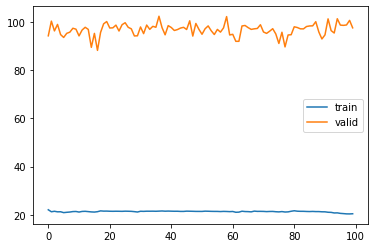

In [38]:
# 학습 곡선을 그려봅시다.
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'valid')
plt.legend()
plt.show()

In [39]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
from sklearn.metrics import mean_squared_error as MSE

y_pred = model.predict(x_test)
MSE(y_test, y_pred) ** 0.5

1/1 [==============================] - 2s 2s/step


96.9181133986877

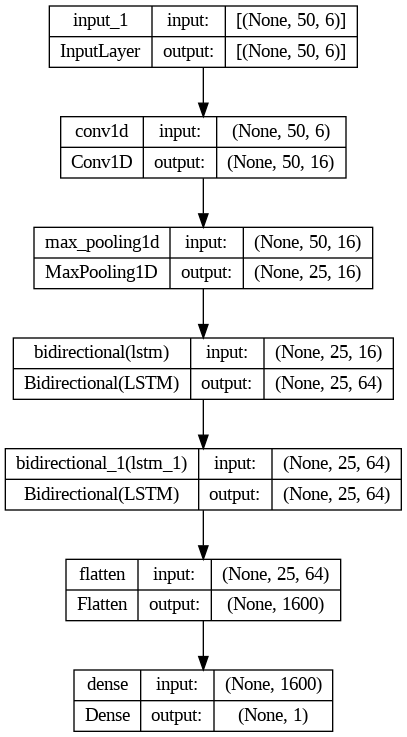

In [40]:
plot_model(model, show_shapes = True)

## Q1. Conv1D + Bidirectional

**[공식문서 적극 참고](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional)**
Bidirectional)**
1. 적절한 인풋 레이어를 구성할 것
2. Conv1D
    * 32개 필터 사용할 것
    * window_size(filter_size)는 10일
    * activation은 swish
3. MaxPool1D
    * 필터 사이즈(window size)는 2일
4. Bidirectional 레이어
    * forward layer : LSTM, 히든스테이트 노드 24개
    * backward layer : GRU, 히든스테이트 노드 16개
4. Bidirectional 레이어
    * forward layer : LSTM, 히든스테이트 노드 24개
    * backward layer : GRU, 히든스테이트 노드 24개
4. 플래튼
6. Fully Connected : 노드 256개, swish
5. 회귀를 위한 적절한 아웃풋 레이어


In [19]:
####################
## Your Code Here ##
####################
# 1. 세션 클리어
clear_session()

# 2. 모델 사슬처럼 엮기
# 인풋 레이어
il = Input(shape = (50, 6)) # 한 번에 50 시점, 시점당 6개 feature 존재

# Conv1D
hl1 = Conv1D(filters = 32,  # 32 종류의 특징을 제작해 줘
            kernel_size = 10, # 한 번에 10시점씩 봐줘야 해
            activation = 'swish',
            padding='same')(il)
# MaxPool1D
hl2 = MaxPool1D(2)(hl1) # 필터 사이즈는 2일

# Bidirectional 레이어
forward_lstm = LSTM(24, return_sequences=True)
backward_gru = GRU(16, return_sequences=True, go_backwards=True) # 너는 지금부터 역행을 해야 되는 아이란다
hl3 = Bidirectional(layer = forward_lstm, backward_layer = backward_gru)(hl2) # 백월드 레이어의 인풋이 있으면 일반 레이어는 포워드 레이어로만 동작합니다.

forward_lstm = LSTM(24, return_sequences=True)
backward_gru = GRU(24, return_sequences=True, go_backwards=True) # 너는 지금부터 역행을 해야 되는 아이란다
hl4 = Bidirectional(layer = forward_lstm, backward_layer = backward_gru)(hl3) # 백월드 레이어의 인풋이 있으면 일반 레이어는 포워드 레이어로만 동작합니다.

# Flatten
hl5 = Flatten()(hl4)

# Fully Connected
hl6 = Dense(256, activation = 'swish')(hl5)

# 회귀를 위한 아웃풋 레이어
ol= Dense(1, activation = 'relu')(hl6)

# 3. 시작, 끝 레이어 지정
model = Model(il, ol)

# 4. 컴파일
model.compile(loss = 'mse', optimizer = 'adam')

# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 6)]           0         
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            1952      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 25, 40)           7872      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 25, 48)           10992     
 nal)                                                            
                                                             

In [20]:
## 학습도 시킬 것
hist = model.fit(x_train,y_train, epochs=100, verbose=1)


Epoch 1/100
136/136 [==============================] - 16s 47ms/step - loss: 5984030294016.0000
Epoch 2/100
136/136 [==============================] - 7s 55ms/step - loss: 5931044700160.0000
Epoch 3/100
136/136 [==============================] - 6s 47ms/step - loss: 5828310466560.0000
Epoch 4/100
136/136 [==============================] - 7s 55ms/step - loss: 5680906895360.0000
Epoch 5/100
136/136 [==============================] - 7s 50ms/step - loss: 5495409082368.0000
Epoch 6/100
136/136 [==============================] - 8s 57ms/step - loss: 5278786912256.0000
Epoch 7/100
136/136 [==============================] - 8s 60ms/step - loss: 5040403120128.0000
Epoch 8/100
136/136 [==============================] - 7s 49ms/step - loss: 4787656982528.0000
Epoch 9/100
136/136 [==============================] - 8s 56ms/step - loss: 4527874899968.0000
Epoch 10/100
136/136 [==============================] - 6s 46ms/step - loss: 4268996427776.0000
Epoch 11/100
136/136 [==========================

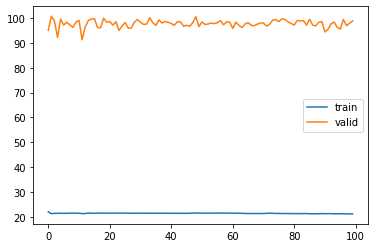

In [33]:
# 학습 곡선을 그려봅시다.
plt.plot(hist.history["loss"], label = 'train')
plt.plot(hist.history["val_loss"], label = 'valid')
plt.legend()
plt.show()

In [34]:
# Q1. 테스트 셋에서의 RMSE를 출력하여라.
from sklearn.metrics import mean_squared_error as MSE

y_pred = model.predict(x_test)
MSE(y_test, y_pred) ** 0.5

1/1 [==============================] - 0s 46ms/step


98.42313243508622

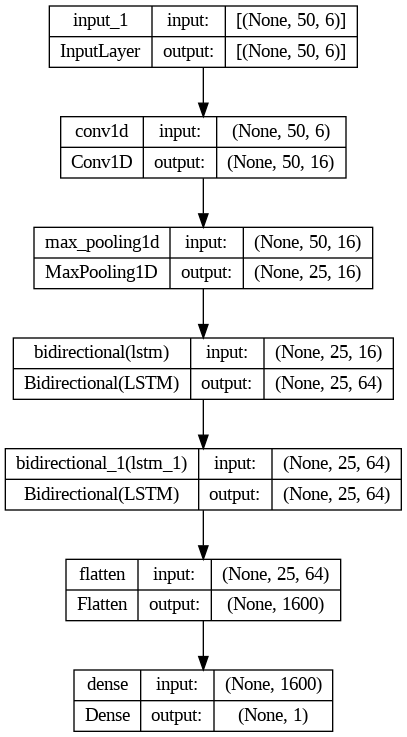

In [35]:
plot_model(model, show_shapes = True)